# Data Import and Cleaning

In [2]:
#1) After importing the data, examine variables such as Dt_Customer and Income to verify their accurate importation

In [3]:
import pandas as pd
import numpy as np
df=pd.read_csv("marketing_data.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [4]:
#2) There are missing income values for some customers. Conduct missing value imputation, considering that customers with similar education and marital status tend to have comparable yearly incomes, on average. 
# Look for problem in the column
print(df['Income'].describe())
print("Missing values in Income:", df['Income'].isnull().sum())

count           2216
unique          1974
top       $7,500.00 
freq              12
Name: Income, dtype: object
Missing values in Income: 24


In [5]:
print(df.pivot_table(index='Education', values='Income', aggfunc='count', margins=True))
print(df.pivot_table(index='Marital_Status', values='Income', aggfunc='count', margins=True))

            Income
Education         
2n Cycle       200
Basic           54
Graduation    1116
Master         365
PhD            481
All           2216
                Income
Marital_Status        
Absurd               2
Alone                3
Divorced           232
Married            857
Single             471
Together           573
Widow               76
YOLO                 2
All               2216


In [6]:
# Recategorize and clean data format
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd', 'Alone', 'YOLO', 'Widow'], 'Other')
df['Education'] = df['Education'].replace(['2n Cycle','Basic'], 'Basic')
print(df['Marital_Status'].value_counts())
print(df['Education'].value_counts())

df['Income'] = df['Income'].str.replace(r'[\$,]', '', regex=True).astype(float)

Married     864
Together    580
Single      480
Divorced    232
Other        84
Name: Marital_Status, dtype: int64
Graduation    1127
PhD            486
Master         370
Basic          257
Name: Education, dtype: int64


In [7]:
# Group Data
income_means = df.groupby(['Education', 'Marital_Status'])['Income'].mean()
print(income_means)

#Impute function
def impute_income(row):
    if pd.isnull(row['Income']): #Only change if income is null
        return income_means[row['Education'], row['Marital_Status']] #Use group mean
    return row['Income'] # Keep original value if not null

df['Income'] = df.apply(impute_income, axis=1)

#Verify result
print("Missing values in Income after imputation:", df['Income'].isnull().sum())

Education   Marital_Status
Basic       Divorced          47734.833333
            Married           41352.980000
            Other             46514.000000
            Single            41862.185185
            Together          40037.142857
Graduation  Divorced          54526.042017
            Married           50800.258741
            Other             55070.351351
            Single            51322.182927
            Together          55758.480702
Master      Divorced          50331.945946
            Married           53286.028986
            Other             59171.923077
            Single            53530.560000
            Together          52109.009804
PhD         Divorced          53096.615385
            Married           58138.031579
            Other             58505.111111
            Single            53314.614583
            Together          56041.422414
Name: Income, dtype: float64
Missing values in Income after imputation: 0


# Create variables

In [8]:
from datetime import datetime
# Create total number of children
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

#Create age
df['Age'] = datetime.now().year - df['Year_Birth']

#Create total spending
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spending_columns].sum(axis=1)

#Create total purchase across channeles
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchase_columns].sum(axis=1)

df[['Total_Children', 'Age', 'Total_Spending', 'Total_Purchases']].head()

,Total_Children,Age,Total_Spending,Total_Purchases
0,0,54,1190,14
1,0,63,577,17
2,1,66,251,10
3,2,57,11,3
4,1,35,91,6


# Plots and Histograms

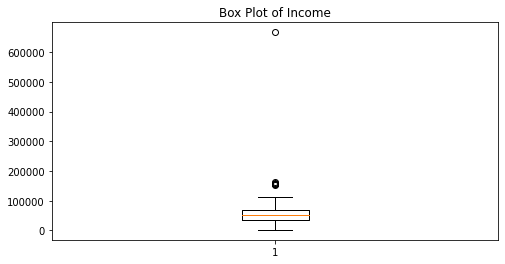

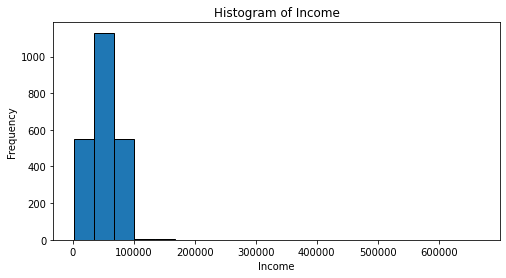

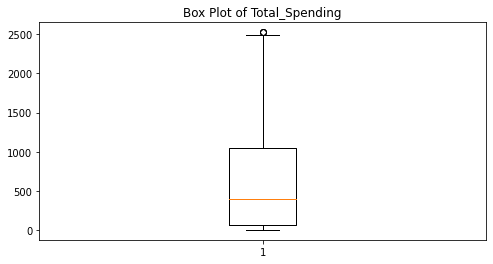

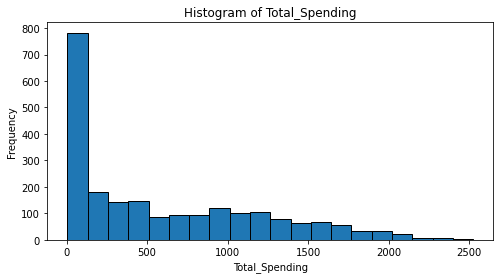

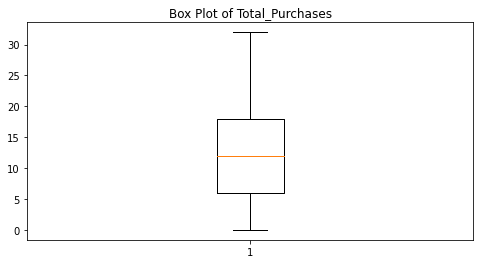

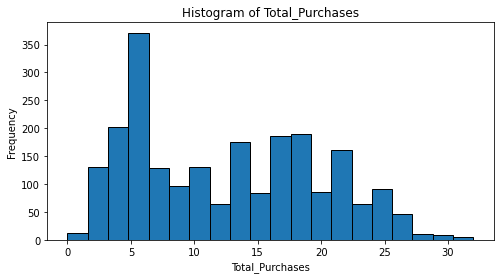

In [9]:
# Generate box plots and histograms to gain insights into the distributions and identify outliers. Implement outlier treatment as needed
import matplotlib.pyplot as plt

columns_to_analyze = ['Income', 'Total_Spending', 'Total_Purchases']
for column in columns_to_analyze:
    # Box plot
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()
    
    # Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(df[column], bins=20, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [10]:
# detect outliers using zscore method
from scipy.stats import zscore

for column in columns_to_analyze:
    z_scores = zscore(df[column])  # Calculate z-scores
    outliers = df[column][(z_scores < -3) | (z_scores > 3)]  # Find values with z-score > 3 or < -3
    print(f'{column} Outliers:')
    print(outliers)

Income Outliers:
325     157146.0
497     160803.0
527     666666.0
731     162397.0
853     157733.0
1826    153924.0
1925    156924.0
2204    157243.0
Name: Income, dtype: float64
Total_Spending Outliers:
671     2525
672     2525
1026    2486
1404    2524
1864    2440
Name: Total_Spending, dtype: int64
Total_Purchases Outliers:
Series([], Name: Total_Purchases, dtype: int64)


In [11]:
# Treat Outliers
def treat_outliers_zscore(df, column, threshold=3):
    # Calculate z-scores
    z_scores = zscore(df[column])

    # Identify upper and lower bounds
    upper_bound = df[column].mean() + threshold * df[column].std()
    lower_bound = df[column].mean() - threshold * df[column].std()

    # Cap values outside the range [-threshold, threshold]
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    print(f'{column}: Capped at [{lower_bound}, {upper_bound}]')
    
# Apply function to columns_to_analyze
for column in columns_to_analyze:
    treat_outliers_zscore(df, column)
    
print("After Outlier Treatment:")
print(df[columns_to_analyze].describe())

Income: Capped at [-22888.15939373651, 127367.27421364817]
Total_Spending: Capped at [-1200.9496497471885, 2412.546078318617]
Total_Purchases: Capped at [-9.080168659922457, 34.1542758027796]
After Outlier Treatment:
              Income  Total_Spending  Total_Purchases
count    2240.000000     2240.000000      2240.000000
mean    51902.995889      605.603005        12.537054
std     21061.021054      601.646800         7.205741
min      1730.000000        5.000000         0.000000
25%     35538.750000       68.750000         6.000000
50%     51371.000000      396.000000        12.000000
75%     68289.750000     1045.500000        18.000000
max    127367.274214     2412.546078        32.000000


# Encoding

In [12]:
# Apply ordinal and one-hot encoding based on the various types of categorical variables
# Apply ordinal encoding for 'Education'
education_map = {
    'Basic': 1,
    'Graduation': 2,
    'Master': 3,
    'PhD': 4
}
df['Education_Ordinal'] = df['Education'].map(education_map)

# Verify the encoding
print(df['Education_Ordinal'].value_counts())


2    1127
4     486
3     370
1     257
Name: Education_Ordinal, dtype: int64


In [13]:
# Apply one-hot encoding for 'Marital_Status'
marital_status_encoded = pd.get_dummies(df['Marital_Status'], prefix='Marital')

# Merge the encoded columns into the original DataFrame
df = pd.concat([df, marital_status_encoded], axis=1)

# Verify the encoding
print(df.head())

      ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0   1826        1970  Graduation       Divorced  84835.0        0         0   
1      1        1961  Graduation         Single  57091.0        0         0   
2  10476        1958  Graduation        Married  67267.0        0         1   
3   1386        1967  Graduation       Together  32474.0        1         1   
4   5371        1989  Graduation         Single  21474.0        1         0   

  Dt_Customer  Recency  MntWines  ...  Total_Children  Age  Total_Spending  \
0   6/16/2014        0       189  ...               0   54          1190.0   
1   6/15/2014        0       464  ...               0   63           577.0   
2   5/13/2014        0       134  ...               1   66           251.0   
3   5/11/2014        0        10  ...               2   57            11.0   
4    4/8/2014        0         6  ...               1   35            91.0   

   Total_Purchases  Education_Ordinal  Marital_Divorced 

# Heat Map

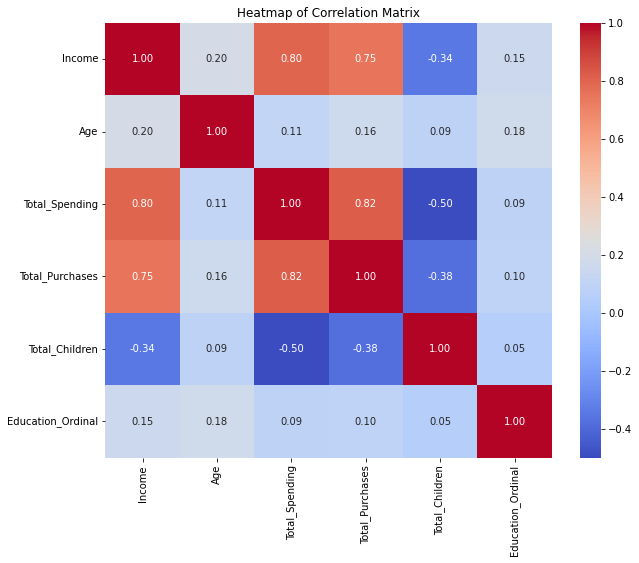

In [14]:
# Generate a heatmap to illustrate the correlation between different pairs of variables
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select specific columns to reduce clutter
columns_to_include = ['Income', 'Age', 'Total_Spending', 'Total_Purchases', 'Total_Children','Education_Ordinal']
correlation_matrix = df[columns_to_include].corr()

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()

# Test Hypotheses

In [15]:
""" 
Hypo 1:
Older individuals may not possess the same level of technological proficiency and may, therefore, 
lean toward traditional in-store shopping preferences.
"""

' \nHypo 1:\nOlder individuals may not possess the same level of technological proficiency and may, therefore, \nlean toward traditional in-store shopping preferences.\n'

In [16]:
import scipy.stats as stats

# Step 1: Create Age Groups (Simplified)
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 60, 100], labels=['<30', '30-60', '>60'])

# Step 2: Perform ANOVA Test
anova_result = stats.f_oneway(
    df[df['Age_Group'] == '<30']['NumStorePurchases'],
    df[df['Age_Group'] == '30-60']['NumStorePurchases'],
    df[df['Age_Group'] == '>60']['NumStorePurchases']
)

# Step 3: Print Hypotheses and Results
print("Hypotheses:")
print("H0: No significant difference in in-store purchases across age groups.")
print("H1: Significant differences in in-store purchases across age groups.")

print(f"\nANOVA Results: F-statistic = {anova_result.statistic:.2f}, p-value = {anova_result.pvalue:.3f}")

# Step 4: Interpret Results
if anova_result.pvalue < 0.05:
    print("Conclusion: Reject H0. Significant differences exist in in-store purchases across age groups.")
else:
    print("Conclusion: Fail to reject H0. No significant differences in in-store purchases across age groups.")

Hypotheses:
H0: No significant difference in in-store purchases across age groups.
H1: Significant differences in in-store purchases across age groups.

ANOVA Results: F-statistic = 21.76, p-value = 0.000
Conclusion: Reject H0. Significant differences exist in in-store purchases across age groups.


In [17]:
"""
Hypo 2:
Customers with children likely experience time constraints, making online shopping a more convenient option.
"""

'\nHypo 2:\nCustomers with children likely experience time constraints, making online shopping a more convenient option.\n'

In [18]:
# Perform Pearson correlation test
correlation, pvalue = stats.pearsonr(df['Total_Children'], df['NumWebPurchases'])

# Print hypotheses and results
print("Hypotheses:")
print("H0: No significant correlation between Total_Children and NumWebPurchases.")
print("H1: Significant correlation exists between Total_Children and NumWebPurchases.")

print(f"\nCorrelation Results: r = {correlation:.2f}, p-value = {pvalue:.3f}")

# Interpret results
if pvalue < 0.05:
    print("Conclusion: Reject H0. Significant correlation exists between Total_Children and NumWebPurchases.")
else:
    print("Conclusion: Fail to reject H0. No significant correlation between Total_Children and NumWebPurchases.")

Hypotheses:
H0: No significant correlation between Total_Children and NumWebPurchases.
H1: Significant correlation exists between Total_Children and NumWebPurchases.

Correlation Results: r = -0.15, p-value = 0.000
Conclusion: Reject H0. Significant correlation exists between Total_Children and NumWebPurchases.


In [19]:
"""
Hypo 3:
Sales at physical stores may face the risk of cannibalization by alternative distribution channels.
"""

'\nHypo 3:\nSales at physical stores may face the risk of cannibalization by alternative distribution channels.\n'

In [20]:
import scipy.stats as stats

# Step 1: Correlation between store purchases and web/catalog purchases
correlation_store_web, pvalue_store_web = stats.pearsonr(df['NumStorePurchases'], df['NumWebPurchases'])
correlation_store_catalog, pvalue_store_catalog = stats.pearsonr(df['NumStorePurchases'], df['NumCatalogPurchases'])

# Step 2: Print hypotheses and results
print("Hypotheses:")
print("H0: No significant relationship between NumStorePurchases and alternative distribution channels (NumWebPurchases, NumCatalogPurchases).")
print("H1: Significant negative relationship exists between NumStorePurchases and alternative distribution channels.")

# Results for Store vs Web Purchases
print(f"\nStore vs Web Purchases: r = {correlation_store_web:.2f}, p-value = {pvalue_store_web:.3f}")
# Results for Store vs Catalog Purchases
print(f"Store vs Catalog Purchases: r = {correlation_store_catalog:.2f}, p-value = {pvalue_store_catalog:.3f}")

# Step 3: Interpret Results
if pvalue_store_web < 0.05:
    print("\nConclusion: Reject H0 for Store vs Web Purchases. Significant negative relationship exists between Store and Web purchases.")
else:
    print("\nConclusion: Fail to reject H0 for Store vs Web Purchases. No significant relationship between Store and Web purchases.")

if pvalue_store_catalog < 0.05:
    print("Conclusion: Reject H0 for Store vs Catalog Purchases. Significant negative relationship exists between Store and Catalog purchases.")
else:
    print("Conclusion: Fail to reject H0 for Store vs Catalog Purchases. No significant relationship between Store and Catalog purchases.")


Hypotheses:
H0: No significant relationship between NumStorePurchases and alternative distribution channels (NumWebPurchases, NumCatalogPurchases).
H1: Significant negative relationship exists between NumStorePurchases and alternative distribution channels.

Store vs Web Purchases: r = 0.50, p-value = 0.000
Store vs Catalog Purchases: r = 0.52, p-value = 0.000

Conclusion: Reject H0 for Store vs Web Purchases. Significant negative relationship exists between Store and Web purchases.
Conclusion: Reject H0 for Store vs Catalog Purchases. Significant negative relationship exists between Store and Catalog purchases.


In [21]:
"""
Does the United States significantly outperform the rest of the world in total purchase volumes?
"""

'\nDoes the United States significantly outperform the rest of the world in total purchase volumes?\n'

In [22]:
# Step 1: Split the data into two groups: United States and Rest of the World
us_data = df[df['Country'] == 'US']['Total_Purchases']
non_us_data = df[df['Country'] != 'US']['Total_Purchases']

# Step 2: Perform a t-test to compare total purchases between the US and the rest of the world
t_stat, p_value = stats.ttest_ind(us_data, non_us_data, equal_var=False)

# Step 3: Print hypotheses and results
print("Hypotheses:")
print("H0: No significant difference in total purchase volumes between the United States and the rest of the world.")
print("H1: The United States significantly outperforms the rest of the world in total purchase volumes.")

print(f"\nT-test Results: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")

# Step 4: Interpret Results
if p_value < 0.05:
    print("Conclusion: Reject H0. The United States significantly outperforms the rest of the world in total purchase volumes.")
else:
    print("Conclusion: Fail to reject H0. No significant difference in total purchase volumes between the United States and the rest of the world.")

Hypotheses:
H0: No significant difference in total purchase volumes between the United States and the rest of the world.
H1: The United States significantly outperforms the rest of the world in total purchase volumes.

T-test Results: t-statistic = 1.47, p-value = 0.145
Conclusion: Fail to reject H0. No significant difference in total purchase volumes between the United States and the rest of the world.


# Visualization

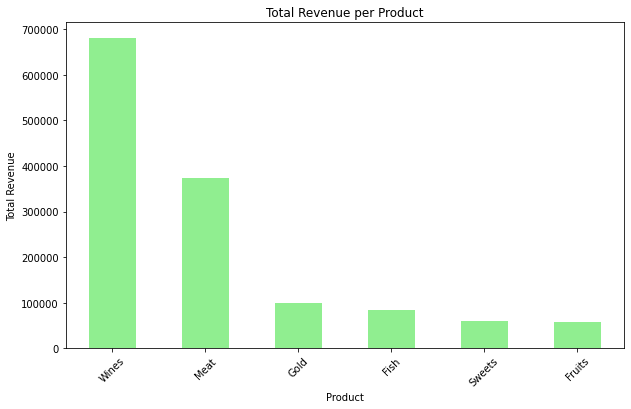

In [23]:
# Identify the top-performing products and those with the lowest revenue.

# List of columns related to products
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Calculate total revenue for each product
product_revenue = df[product_columns].sum()

# Create a dictionary to map the original product names to new names
product_labels = {
    'MntWines': 'Wines',
    'MntFruits': 'Fruits',
    'MntMeatProducts': 'Meat',
    'MntFishProducts': 'Fish',
    'MntSweetProducts': 'Sweets',
    'MntGoldProds': 'Gold'
}

# Rename the product columns for the bar chart
product_revenue = product_revenue.rename(product_labels)
product_revenue = product_revenue.sort_values(ascending=False)

# Plotting a bar chart for total revenue per product
plt.figure(figsize=(10, 6))
product_revenue.plot(kind='bar', color='lightgreen')
plt.title('Total Revenue per Product')
plt.xlabel('Product')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

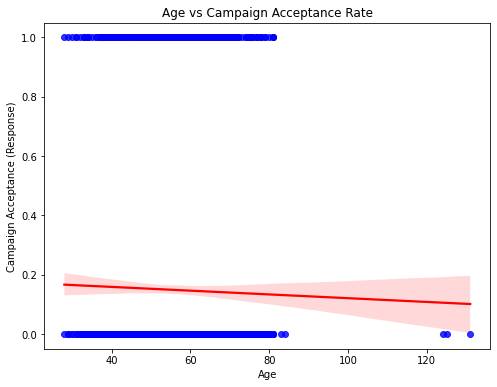

correlation coefficient: -0.02


In [24]:
# Examine if there is a correlation between customers' age and the acceptance rate of the last campaign.



plt.figure(figsize=(8, 6))
sns.regplot(x='Age', y='Response', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Age vs Campaign Acceptance Rate')
plt.xlabel('Age')
plt.ylabel('Campaign Acceptance (Response)')
plt.show()

correlation = df['Age'].corr(df['Response'])
print(f"correlation coefficient: {correlation:.2f}")

SP     176
SA      52
CA      38
AUS     23
GER     17
IND     13
US      13
ME       2
Name: Country, dtype: int64


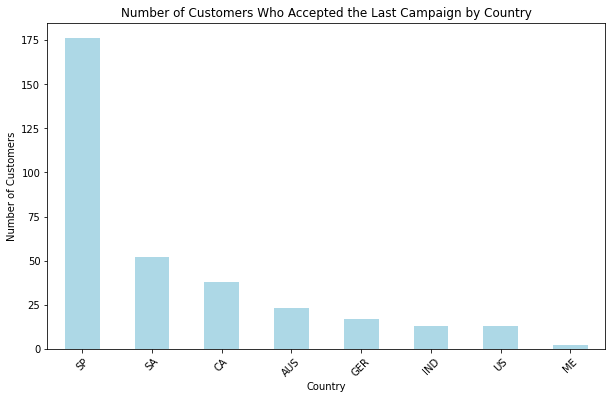

In [25]:
# Determine the country with the highest number of customers who accepted the last campaign

# Filter customers who accepted the last campaign (Response == 1)
country_acceptance = df[df['Response'] == 1]['Country'].value_counts()
print(country_acceptance)

# Plotting a bar chart for the number of customers per country who accepted the campaign
plt.figure(figsize=(10, 6))
country_acceptance.plot(kind='bar', color='lightblue')
plt.title('Number of Customers Who Accepted the Last Campaign by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

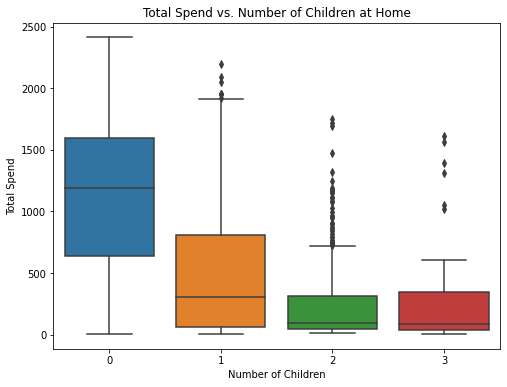

In [27]:
#Investigate if there is a discernible pattern in the number of children at home and the total expenditure.

plt.figure(figsize=(8, 6))
sns.boxplot(x='Total_Children', y='Total_Spending', data=df)
plt.title('Total Spend vs. Number of Children at Home')
plt.xlabel('Number of Children')
plt.ylabel('Total Spend')
plt.show()

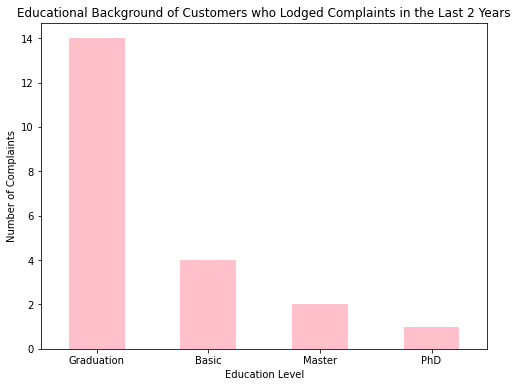

In [36]:
# Analyze the educational background of customers who lodged complaints in the last two years

# Filter the data for customers who lodged complaints in the last two years
education_complaints = df[df['Complain'] == 1]['Education'].value_counts()

# Plotting a bar chart for the number of complaints by education level
plt.figure(figsize=(8, 6))
education_complaints.plot(kind='bar', color='pink')
plt.title('Educational Background of Customers who Lodged Complaints in the Last 2 Years')
plt.xlabel('Education Level')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=0)
plt.show()